## Import libraries

In [27]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import nltk
import numpy as np
import re
import string
from nltk.corpus import stopwords

## Analyse and preprocess the dataset

In [28]:
data = pd.read_csv('Data/tweets.csv', encoding='latin', names=['polarity','id','date','query','user','text'])

In [29]:
data.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [30]:
print("Dataset shape:", data.shape)

Dataset shape: (1600000, 6)


In [31]:
data = data.sample(frac=1)
data = data[:200000]

In [32]:
#Unique output values
data['polarity'].unique()

array([0, 4])

In [33]:
#4 denotes positive. We'll replace 4 with 1 for easy understanding

data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
24506,0,1558023767,Sun Apr 19 06:59:11 PDT 2009,NO_QUERY,rmg112562,Can't seem to retrieve files from old hard dri...
826616,1,1556706064,Sat Apr 18 23:58:04 PDT 2009,NO_QUERY,MyNameIsJaxon,@storycorey
920579,1,1754024423,Sun May 10 04:37:45 PDT 2009,NO_QUERY,mongoboyjackson,vettel vs f95... thank god there is more than ...
258059,0,1985105425,Sun May 31 16:26:31 PDT 2009,NO_QUERY,Deegee_Cakes,Omg I cleaned this house from top to bottom wi...
1154762,1,1978947585,Sun May 31 01:02:17 PDT 2009,NO_QUERY,Daddys_pet,@fudgecrumpet *juggles* - hows that?


In [34]:
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.498805,1.999084e+09
std,0.500000,1.933756e+08
min,0.000000,1.467811e+09
25%,0.000000,1.957040e+09
50%,0.000000,2.002104e+09
75%,1.000000,2.177006e+09
max,1.000000,2.329206e+09


Total sentences:  200000
Negative sentences:  99761
Positive sentences:  100239


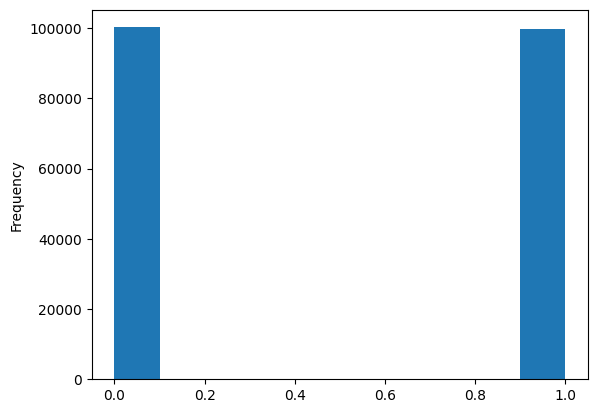

In [35]:
#Count of posive and negative sentences
data['polarity'].plot(kind='hist')
print('Total sentences: ',data.shape[0])
print('Negative sentences: ',len(data[data['polarity'] == 1]))
print('Positive sentences: ',len(data[data['polarity'] == 0]))

In [36]:
#Get word count for a given text
def word_count(words):
    return len(words.split())

**Word count of positive and negative tweets**

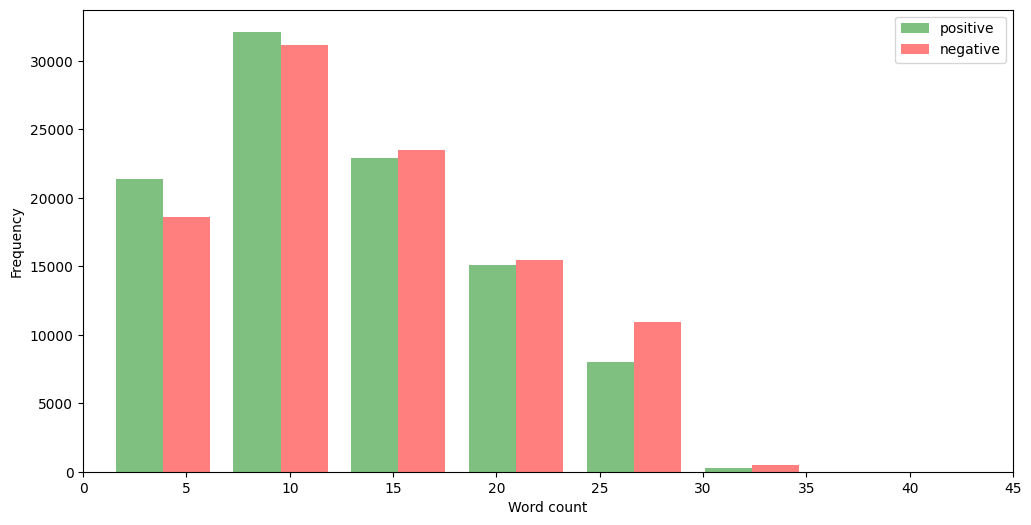

In [37]:
#Word distribution for positive and negative words

data['word count'] = data['text'].apply(word_count)
wc_pos = data[data['polarity'] == 1]['word count']
wc_neg = data[data['polarity'] == 0]['word count']

plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')

g = plt.hist([wc_pos, wc_neg], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

**Common words**

In [38]:
#Get common words and displaying the 20 most common ones
from collections import Counter
all_words = []

for line in list(data['text']):
    words = line.split()
    for word in words:
        if(len(word) > 2):
            all_words.append(word.lower())

Counter(all_words).most_common(20)

[('the', 64409),
 ('and', 37112),
 ('you', 29947),
 ('for', 26887),
 ('have', 17769),
 ('that', 16135),
 ("i'm", 15984),
 ('but', 15508),
 ('just', 15468),
 ('with', 14257),
 ('was', 12851),
 ('not', 12648),
 ('this', 11007),
 ('get', 10082),
 ('are', 9653),
 ('good', 9546),
 ('like', 9266),
 ('all', 9259),
 ('out', 8688),
 ("it's", 8073)]

In [39]:
#Removing the columns which are not necessary
data.drop(['id','date', 'query', 'user','word count'], axis=1, inplace=True)

In [40]:
data

,polarity,text
24506,0,Can't seem to retrieve files from old hard dri...
826616,1,@storycorey
920579,1,vettel vs f95... thank god there is more than ...
258059,0,Omg I cleaned this house from top to bottom wi...
1154762,1,@fudgecrumpet *juggles* - hows that?
...,...,...
808416,1,@anukrishna send me some hot weather I will se...
266709,0,I'm venturing out without a jacket today. I fe...
1260222,1,@BethFishReads I'm wiley like that
685873,0,Why is it not raining anymore?


In [41]:
#Checking for null values
print(data.isnull().sum())

polarity    0
text        0
dtype: int64


In [42]:
data.dtypes

polarity     int64
text        object
dtype: object

In [43]:
#Converting text from object type to str
data['text'] = data['text'].astype('str')

**Download stopwords**

In [44]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/surbhit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/surbhit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/surbhit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
#nltk.download('stopwords')
stopwords_english = set(stopwords.words('english'))
print('Total english stopwords: ', len(stopwords_english))
print(stopwords_english)

Total english stopwords:  179
{'own', 'just', 'shouldn', 'do', 'more', 'here', 'nor', 'with', 'up', 'too', 'isn', 'shan', 'against', 'down', "won't", "mustn't", 'couldn', 'y', "isn't", 'an', 'will', 'now', 'but', 'having', 'had', 'further', 'we', 'my', 'weren', 'who', 'from', 'ours', 'mightn', 'should', 'at', "should've", 't', 'very', 'below', 'off', 'be', 'under', 'wouldn', 'is', 'his', 'these', 'wasn', "you'd", "she's", "you've", 'out', "mightn't", 'can', 'above', 'by', 'hers', 'she', 'they', 'few', 'you', "hasn't", "shouldn't", 'has', 'are', 'which', 'yours', 'yourselves', 'into', 'why', 'your', 'that', 'because', 'yourself', 'he', 'such', 'was', 'doing', "you'll", 'didn', 'any', "don't", 've', 'itself', 'aren', 'in', 'it', 'does', 'as', 'after', 'whom', 'than', 'm', 'theirs', 'or', 'himself', 'themselves', 'and', 'haven', 'once', 'on', 'so', 'her', 'how', 'mustn', 's', 'again', 'when', 'where', 'o', "aren't", 'him', 'before', 'some', 're', 'hasn', 'each', "doesn't", 'only', 'll', '

Preprocessing steps:
1. Removing urls, username
2. Convert to lower case
3. Remove punctuations
4. Remove stopwords
5. Tokenization and Lemmetization

In [46]:
#Pattern for finding https:// or http:// or www.
urlPattern = r"((https://)[^ ]*|(http://)[^ ]*|(www\.)[^ ]*)"

#Pattern for finding @<>
userPattern = '@[^\s]+'

def process_text(text):
    #Lower case
    text = text.lower()
    #text = text[1:]

    #Removing urls
    text = re.sub(urlPattern,'',text)
    
    #Removing usernames
    text = re.sub(userPattern,'',text)
    
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    
    #Tokenization
    tokens = word_tokenize(text)
    
    #Removing stopwords
    final_token = [tkn for tkn in tokens if tkn not in stopwords_english]

    #Lemmetization
    wordLemm = WordNetLemmatizer()
    final_words = []
    for t in final_token:
        if len(t) > 1:
            word = wordLemm.lemmatize(t)
            final_words.append(word)

    return ' '.join(final_words)

In [47]:
data['processed_tweets'] = data['text'].apply(lambda x:process_text(x))
print('Text preprocessing complete')

Text preprocessing complete


In [36]:
data.head()

,polarity,text,processed_tweets
1354593,1,"OK folks, going off for awhile. See you on the...",ok folk going awhile see train home later
573116,0,I think i was meant for bigger things that to ...,think meant bigger thing write report admin wo...
62900,0,@sbmczh bahahaha! Sorry for that. And degradin...,bahahaha sorry degrading aw didnt mean offend
49360,0,hates taking the bus in the morning..,hate taking bus morning
285355,0,Have not had a moment to myself at home for da...,moment home dayshubby always trying staff arou...


In [37]:
def create_word_cloud(feature,polarity_value,max_words=2000, width=1600, height=800):
    plt.figure(figsize=(15,15))
    wc = WordCloud(max_words=max_words, width=width, height=height).generate(" ".join(data[data[feature] == polarity_value].processed_tweets))
    plt.imshow(wc , interpolation = 'bilinear')

**Wordcloud for negative words**

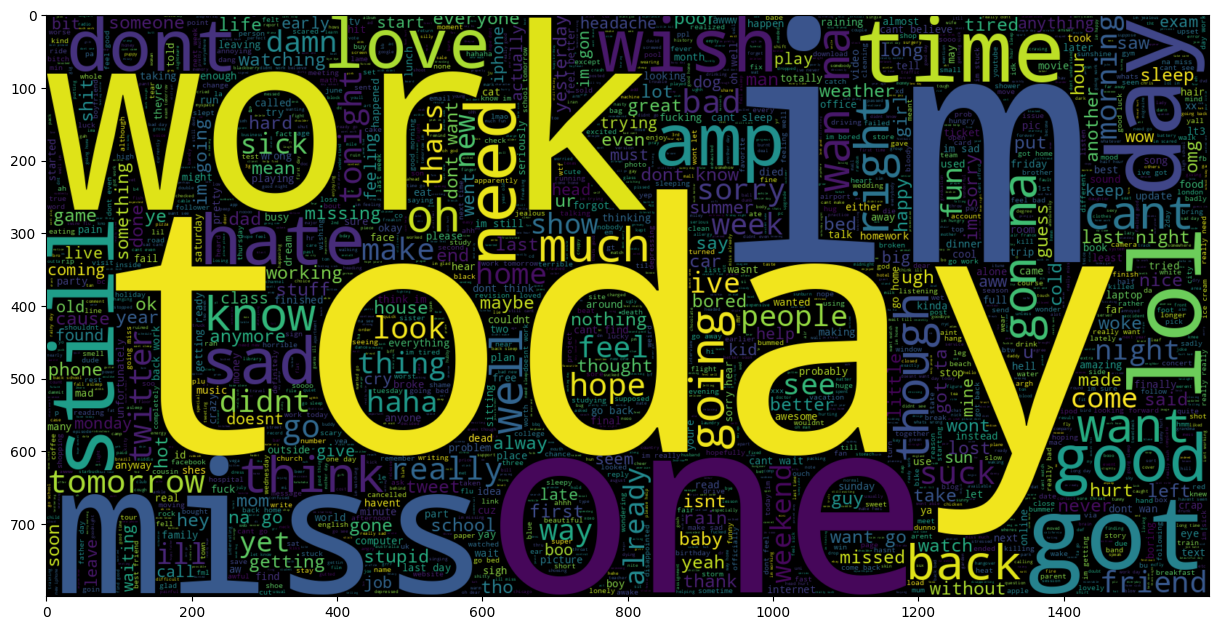

In [38]:
#Wordcloud for negative words
create_word_cloud('polarity',0)

**Wordcloud for positive words**

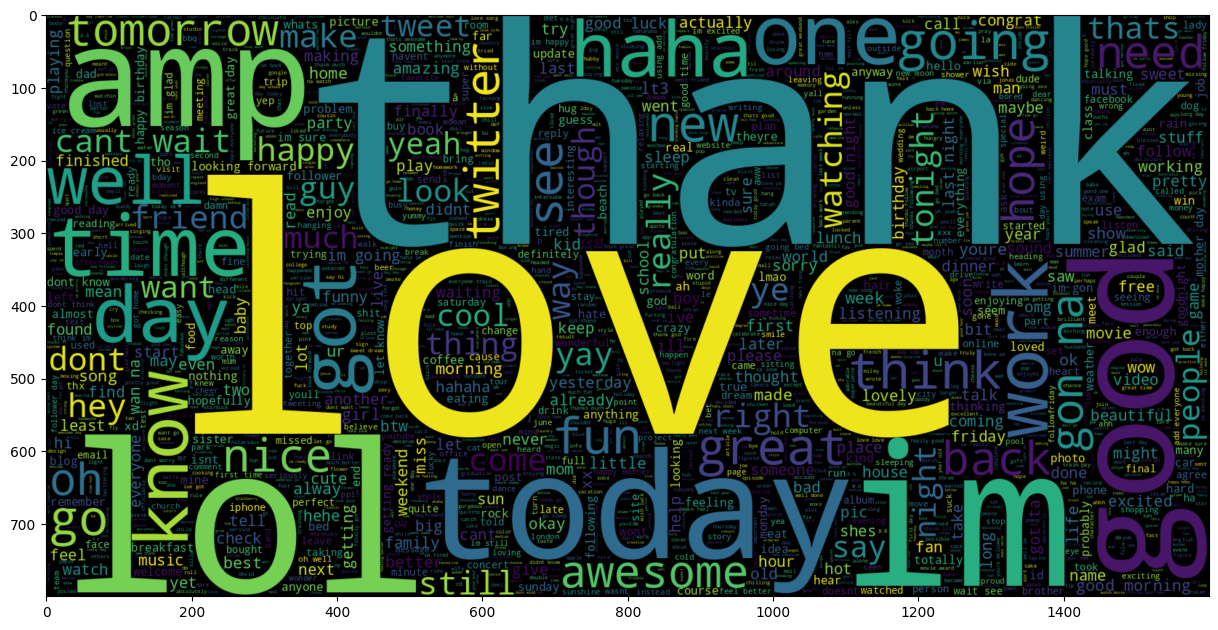

In [39]:
#Wordcloud for positive words
create_word_cloud('polarity',1)

In [40]:
X = data['processed_tweets'].values
y = data['polarity'].values

In [41]:
print('Shape of X: ',X.shape)
print('Shape of y: ',y.shape)

Shape of X:  (200000,)
Shape of y:  (200000,)


## Modelling

**Using TF-IDF**

In [42]:
tfidf = TfidfVectorizer(sublinear_tf=True)
X = tfidf.fit_transform(X)
print('Number of features: ',len(tfidf.get_feature_names_out()))

Number of features:  101354


In [43]:
print(X.shape)
print(y.shape)

(200000, 101354)
(200000,)


**Train(80) and test(20) split**

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [45]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 101354)
y_train (160000,)

X_test (40000, 101354)
y_test (40000,)


**This function takes the model as input and does the training and testing. It will also print the confusion matrix and classification report=**

In [46]:
def evaluate_model(model):
    #Training accuracy
    accuracy_train = model.score(X_train, y_train)
    print('Training accuracy: {}'.format(accuracy_train*100))

    #Testing accuracy
    accuracy_test = model.score(X_test, y_test)
    print('Testing accuracy: {}'.format(accuracy_test*100))

    #Prediction on test data
    y_pred = model.predict(X_test)

    #Classification report
    print(classification_report(y_test, y_pred))

    #Confusion matrix
    matrix = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['False', 'True'])
    cm_display.plot()
    plt.show()

**Logistic Regression**

/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy: 82.04875
Testing accuracy: 77.32
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     19879
           1       0.76      0.80      0.78     20121

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



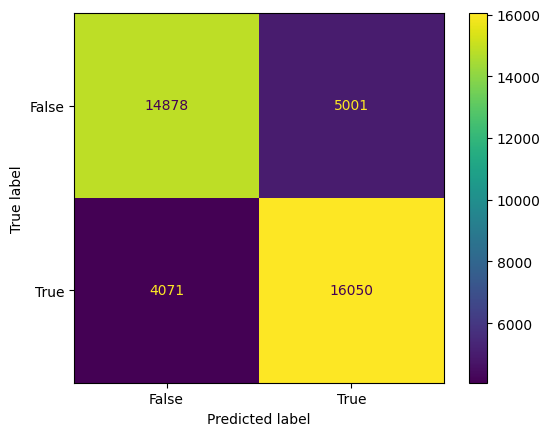

In [47]:
model_log_reg = LogisticRegression()
history_log_reg = model_log_reg.fit(X_train, y_train)
evaluate_model(model_log_reg)

**Linear SVM**

Training accuracy: 88.1075
Testing accuracy: 76.06
              precision    recall  f1-score   support

           0       0.77      0.74      0.75     19879
           1       0.75      0.78      0.77     20121

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



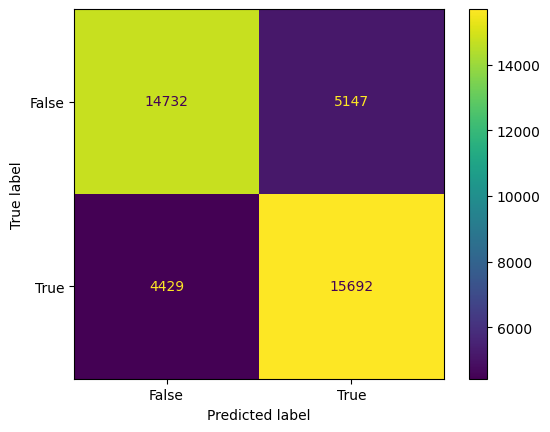

In [48]:
model_svc = LinearSVC()
history_svc = model_svc.fit(X_train, y_train)
evaluate_model(model_svc)

**Random Forest**

Training accuracy: 75.65875
Testing accuracy: 71.2975
              precision    recall  f1-score   support

           0       0.76      0.62      0.68     19879
           1       0.68      0.80      0.74     20121

    accuracy                           0.71     40000
   macro avg       0.72      0.71      0.71     40000
weighted avg       0.72      0.71      0.71     40000



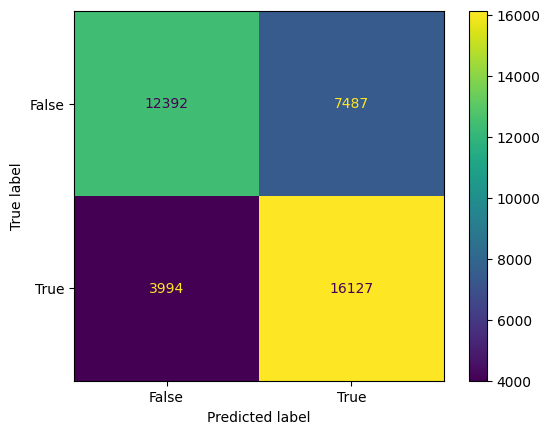

In [49]:
model_rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
history_rf = model_rf.fit(X_train, y_train)
evaluate_model(model_rf)

Training accuracy: 78.9
Testing accuracy: 73.86749999999999
              precision    recall  f1-score   support

           0       0.77      0.68      0.72     19879
           1       0.72      0.79      0.75     20121

    accuracy                           0.74     40000
   macro avg       0.74      0.74      0.74     40000
weighted avg       0.74      0.74      0.74     40000



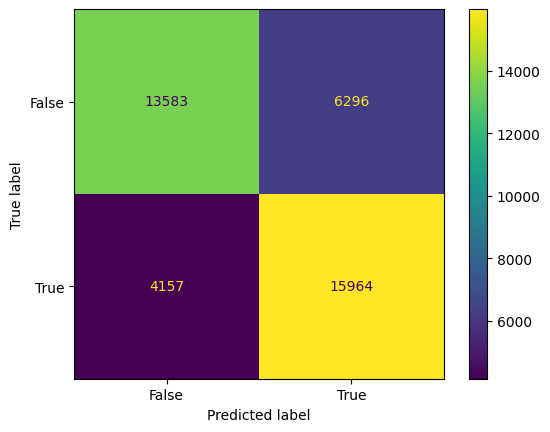

In [50]:
model_rf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth=50)
history_rf = model_rf.fit(X_train, y_train)
evaluate_model(model_rf)

**Naive Bayes**

Training accuracy: 83.316875
Testing accuracy: 76.25999999999999
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     19879
           1       0.76      0.76      0.76     20121

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



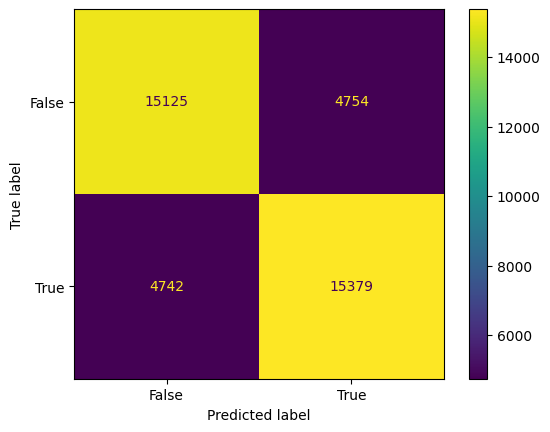

In [51]:
model_nb = BernoulliNB()
history_nb = model_nb.fit(X_train, y_train)
evaluate_model(model_nb)

### Predictions on the models

In [52]:
categories = ["Negative", "Positive"]
def predict(sent,model):
    sent = [sent]
    sentence_test = tfidf.transform(sent)
    pred = model.predict(sentence_test)
    return categories[pred[0]]


In [53]:
#Logistic Regression
p = predict("I enjoy working on this", model_log_reg)
print("I enjoy working on this - ", p)

p = predict("I don't enjoy working on this", model_log_reg)
print("I don't enjoy working on this - ", p)

p = predict("I hate working on this", model_log_reg)
print("I hate working on this - ", p)

I enjoy working on this -  Positive
I don't enjoy working on this -  Positive
I hate working on this -  Negative


In [54]:
#SVC
p = predict('This does not look amazing', model_svc)
print("This does not look amazing - ", p)

p = predict('This looks amazing', model_svc)
print("This looks amazing - ", p)

p = predict('This is horrible', model_svc)
print("This is horrible - ", p)

This does not look amazing -  Positive
This looks amazing -  Positive
This is horrible -  Negative


In [55]:
#Random Forest
p = predict("I enjoy working on this", model_rf)
print("I enjoy working on this - ", p)

p = predict("I don't enjoy working on this", model_rf)
print("I don't enjoy working on this - ", p)

p = predict("I hate working on this", model_rf)
print("I hate working on this - ", p)

I enjoy working on this -  Positive
I don't enjoy working on this -  Positive
I hate working on this -  Negative


In [56]:
#Naive Bayes
p = predict('This does not look amazing', model_nb)
print("This does not look amazing - ", p)

p = predict('This looks amazing', model_nb)
print("This looks amazing - ", p)

p = predict('This is horrible', model_nb)
print("This is horrible - ", p)

This does not look amazing -  Positive
This looks amazing -  Positive
This is horrible -  Negative


**We'll deploy the Naive Bayes model for prediction**

In [57]:
import pickle

In [58]:
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))
pickle.dump(model_nb, open('NaiveBayes.pkl','wb'))

In [59]:
sent = "I hate you"
sent = [sent]
sentence_test = tfidf.transform(sent)
pred = model_nb.predict(sentence_test)

In [60]:
pred

array([0])

#### Using LSTM

In [48]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

In [26]:
#data = pd.read_csv('Data/tweets.csv', encoding='latin', names=['polarity','id','date','query','user','text'])

In [49]:
#4 denotes positive. We'll replace 4 with 1 for easy understanding

data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,text,processed_tweets
24506,0,Can't seem to retrieve files from old hard dri...,cant seem retrieve file old hard drivegeek squ...
826616,1,@storycorey,
920579,1,vettel vs f95... thank god there is more than ...,vettel v f95 thank god one screen parent home
258059,0,Omg I cleaned this house from top to bottom wi...,omg cleaned house top bottom bleach nose burni...
1154762,1,@fudgecrumpet *juggles* - hows that?,juggle hows


In [50]:
X = data['processed_tweets']
y = data['polarity']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=44)
print('Train size: ',X_train.shape)
print('Test size: ',X_test.shape)

Train size:  (160000,)
Test size:  (40000,)


In [51]:
vocab_size = 3000
oov_tok = ''
embedding_dim = 100
max_length = 200
padding_type = 'post'
trunc_type = 'post'

In [52]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

In [53]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

2023-06-09 23:49:13.511244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-09 23:49:13.515391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-09 23:49:13.515714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [54]:
num_epochs = 5
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5


2023-06-09 23:49:19.260549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 23:49:19.262244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 23:49:19.263168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/bidirectional/forward_lstm/PartitionedCall]] [Op:__inference_train_function_5328]

In [55]:
data.to_csv('Sentiment-Analysis-Processed.csv')

In [56]:
data

,polarity,text,processed_tweets
24506,0,Can't seem to retrieve files from old hard dri...,cant seem retrieve file old hard drivegeek squ...
826616,1,@storycorey,
920579,1,vettel vs f95... thank god there is more than ...,vettel v f95 thank god one screen parent home
258059,0,Omg I cleaned this house from top to bottom wi...,omg cleaned house top bottom bleach nose burni...
1154762,1,@fudgecrumpet *juggles* - hows that?,juggle hows
...,...,...,...
808416,1,@anukrishna send me some hot weather I will se...,send hot weather send cold weather fed cold we...
266709,0,I'm venturing out without a jacket today. I fe...,im venturing without jacket today feel strange...
1260222,1,@BethFishReads I'm wiley like that,im wiley like
685873,0,Why is it not raining anymore?,raining anymore


In [57]:
import pickle

In [64]:
lstm_tokenizer = pickle.load(open('LSTM/finalized_tokenizer.pkl', 'rb'))
lstm_model = pickle.load('LSTM/model.pickle')

TypeError: file must have 'read' and 'readline' attributes

In [67]:
lstm_tokenizer = pickle.load(open('LSTM/tokenizer.pickle', 'rb'))
lstm_model = pickle.load(open('LSTM/model.pickle', 'rb'))

In [68]:
from keras.utils import pad_sequences
sent = ['This is amazing']
pre = pad_sequences(lstm_tokenizer.texts_to_sequences(sent),maxlen = 30)

In [69]:
lstm_model.predict(pre)

2023-06-10 02:25:38.890533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.1.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-06-10 02:25:38.897702: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1068 : UNIMPLEMENTED: DNN library is not found.
2023-06-10 02:25:38.897752: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: DNN library is not found.
	 [[{{node model/conv1d/Conv1D}}]]


UnimplementedError: Graph execution error:

Detected at node 'model/conv1d/Conv1D' defined at (most recent call last):
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_9365/381127895.py", line 1, in <cell line: 1>
      lstm_model.predict(pre)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1d/Conv1D'
DNN library is not found.
	 [[{{node model/conv1d/Conv1D}}]] [Op:__inference_predict_function_6850]